#### Since I do not have access to the customer subscriptions, I just created a dummy one.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from scipy import stats
plt.style.use('fivethirtyeight') 

#Reading only the dates and discarding the time 
dateparse = lambda x: pd.datetime.strptime(x[:10],'%Y-%m-%d')
customer_demographics = pd.read_csv("https://assets.datacamp.com/production/repositories/1646/datasets/01054025eb094ac1086edf8d206b313b84d911c5/user_demographics_paywall.csv" \
                                 ,parse_dates=['reg_date'])
#                                   ,parse_dates=['reg_date'], date_parser=dateparse)

#Creating the customer subscription data-set
def random_dates(start, end, n=10):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

start = pd.to_datetime(customer_demographics.reg_date.min())
end = pd.to_datetime(customer_demographics.reg_date.max())

customer_subscriptions = pd.DataFrame({
 "uid" : customer_demographics.uid,
 "lapse_date":random_dates(start,end,customer_demographics.shape[0]),
 "subscription_date":random_dates(start + timedelta(2),end, customer_demographics.shape[0]),
 "price":list(np.random.randint(400,500,customer_demographics.shape[0]))
 })


#creating random null values
index = customer_subscriptions.sample(frac=0.05, random_state=1).index
for i in index:
    customer_subscriptions.iloc[index.get_loc(i),np.random.randint(1,4)] = np.nan

#Merging the two datasets
demo_agg = customer_demographics.merge(customer_subscriptions, how='inner', on=['uid'])
demo_agg.set_index('uid',inplace =True)


## EDA

In [2]:
demo_agg.info()
demo_agg.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 52774929 to 32942475
Data columns (total 8 columns):
reg_date             1100 non-null datetime64[ns, UTC]
device               1100 non-null object
gender               1100 non-null object
country              1100 non-null object
age                  1100 non-null int64
lapse_date           1085 non-null datetime64[ns]
subscription_date    1079 non-null datetime64[ns]
price                1081 non-null float64
dtypes: datetime64[ns, UTC](1), datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 77.3+ KB


,age,price
count,1100.000000,1081.000000
mean,24.798182,448.392229
std,10.689479,28.970318
min,15.000000,400.000000
25%,17.000000,424.000000
50%,21.000000,447.000000
75%,29.000000,474.000000
max,85.000000,499.000000


In [3]:
demo_agg.isnull().sum()

reg_date              0
device                0
gender                0
country               0
age                   0
lapse_date           15
subscription_date    21
price                19
dtype: int64

In [4]:
demo_agg.head()

,reg_date,device,gender,country,age,lapse_date,subscription_date,price
uid,,,,,,,,
52774929,2018-03-07 00:00:00+00:00,and,F,FRA,27,2015-04-22 07:42:14,NaT,481.0
40143397,2016-07-02 00:00:00+00:00,and,F,DEU,56,NaT,2017-11-06 21:04:28,445.0
89856430,2017-06-05 00:00:00+00:00,and,M,TUR,31,NaT,2016-07-07 20:54:41,402.0
76188504,2016-09-24 00:00:00+00:00,iOS,M,BRA,54,2017-10-01 13:38:05,NaT,443.0
76493748,2017-06-07 00:00:00+00:00,iOS,M,BRA,24,2016-05-02 13:16:48,2016-04-27 20:01:23,NaN


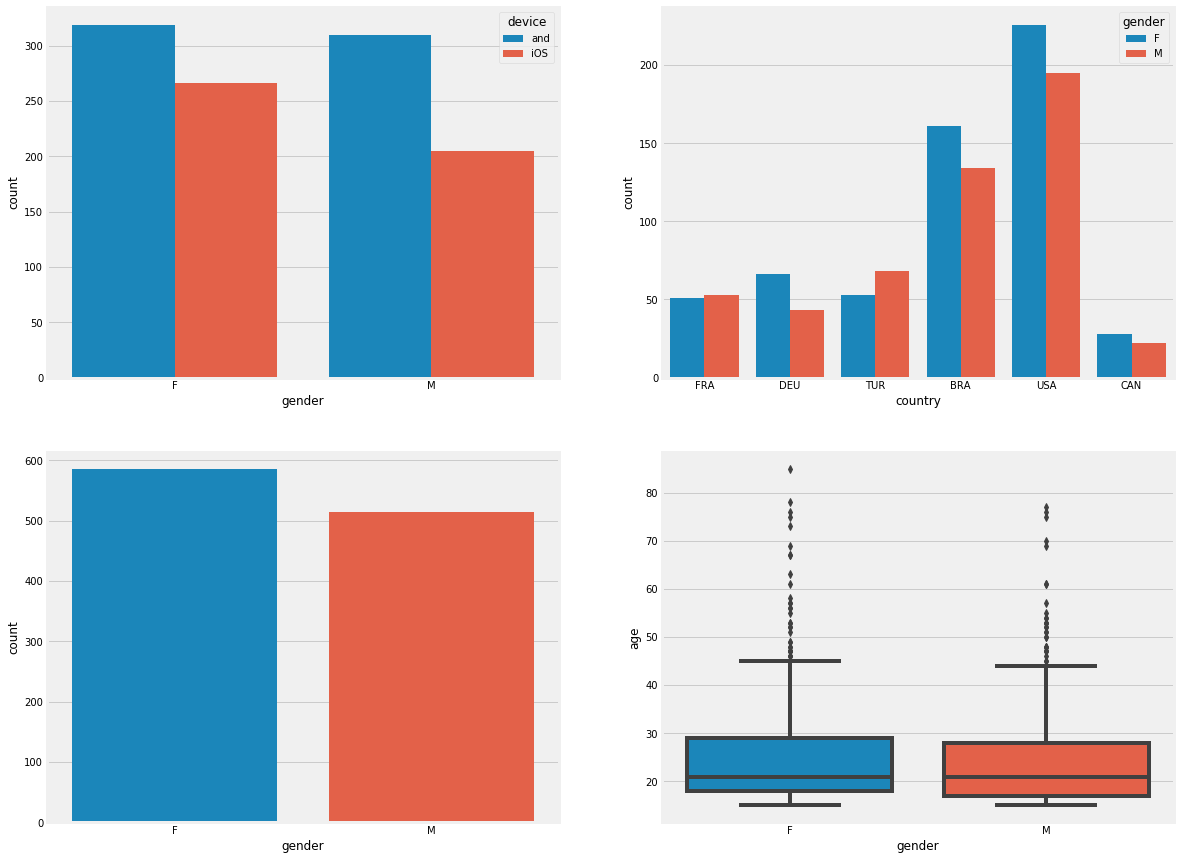

In [5]:
f,ax=plt.subplots(2,2,figsize=(18,15))
sns.countplot(demo_agg.gender, hue=demo_agg.device,ax=ax[0][0])
sns.countplot(demo_agg.country, hue=demo_agg.gender, ax = ax[0][1])
sns.countplot(demo_agg.gender, ax = ax[1][0])
sns.boxplot(y= demo_agg.age,x=demo_agg.gender,ax = ax[1][1])

In [6]:
demo_agg.gender.value_counts()

F    585
M    515
Name: gender, dtype: int64

### Dealing with missing variables

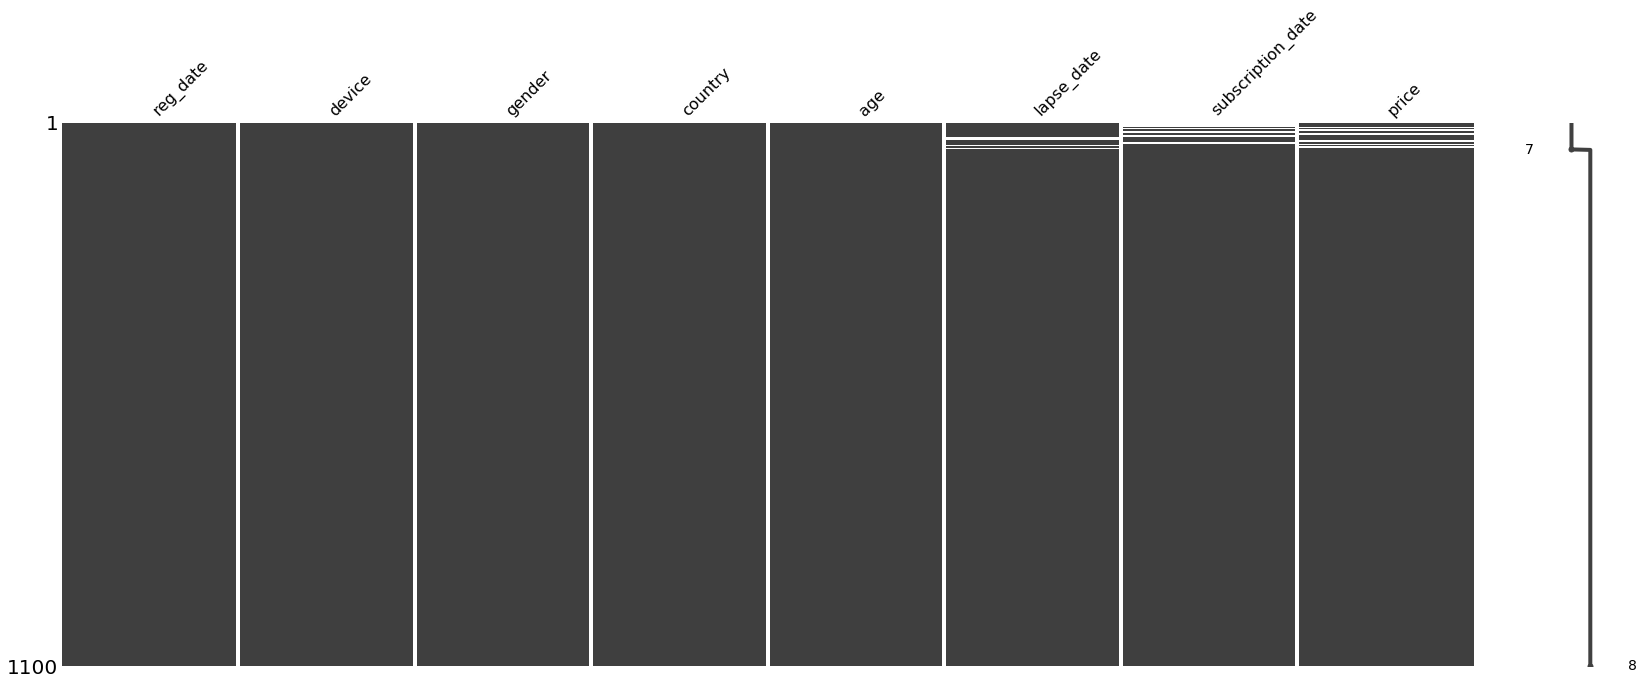

In [7]:
a = demo_agg.isnull()
msno.matrix(demo_agg)

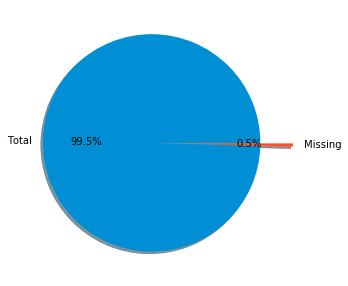

In [8]:
#The percentage of missing values to the total is 5% so it is alright to drop it.
percentage_of_missing_values=demo_agg.isnull().sum().sum() / demo_agg.shape[0] *100
demo_agg.shape[0]
f1,ax1 = plt.subplots(figsize=(5,5))
ax1.pie([demo_agg.shape[0],percentage_of_missing_values], labels=['Total','Missing'],explode=(0,0.3),shadow=True,autopct='%1.1f%%')
plt.show()

In [9]:
#Dropping all of the null values
demo_agg=demo_agg.dropna()
demo_agg.isnull().sum().sum()

0

### A/B testing

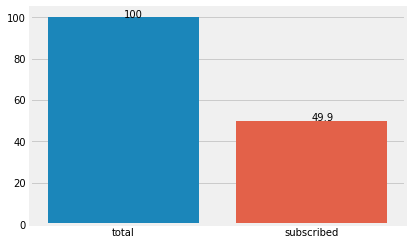

In [171]:
demo_agg[["reg_date","lapse_date"]].max()
current_date = pd.to_datetime("2018-03-17")

# Max lapse day, a week before today
max_lapse_date = current_date - timedelta(7)

#Selecting the users that lapsed before the lapse day
conv_users = demo_agg[(demo_agg.lapse_date < max_lapse_date)]
total_user_count = conv_users.price.count()
max_sub_date = conv_users.lapse_date+timedelta(days=7)

#Filterning non zero subscriptions
total_subs = conv_users[(conv_users.price > 0) & (conv_users.subscription_date <= max_sub_date)]
conversion_rate = total_subs.price.count() / total_user_count

x=['total','subscribed']
y=[100,np.round(conversion_rate*100, decimals=2)]
count = sns.barplot(x,y)
for i,v in enumerate(x):
         count.text(i, y[i],y[i])


In [185]:
measure=['mean','min','max']
agg = total_subs.groupby(['gender','device'], as_index=False).agg({'price':measure, 'age':measure})
agg

gender device       price                      age        
                       mean    min    max       mean min max
0      F    and  449.957143  402.0  499.0  25.414286  15  76
1      F    iOS  453.464567  400.0  499.0  25.212598  15  75
2      M    and  448.780822  400.0  499.0  23.273973  15  76
3      M    iOS  448.222222  400.0  497.0  24.120370  15  61

### Cohort conversion rate

In [109]:
total_subs

,reg_date,device,gender,country,age,lapse_date,subscription_date,price
uid,,,,,,,,
47634767,2017-02-21 00:00:00+00:00,and,M,USA,18,2016-10-13 09:25:45,2016-03-05 01:55:07,494.0
62002686,2015-12-06 00:00:00+00:00,iOS,M,USA,35,2016-09-23 17:05:26,2015-04-01 04:06:00,401.0
23273361,2018-01-17 00:00:00+00:00,and,F,DEU,18,2016-07-23 18:00:52,2016-05-14 20:27:27,404.0
97420971,2017-03-07 00:00:00+00:00,and,M,TUR,32,2017-11-14 07:01:25,2016-11-11 09:39:37,403.0
83886673,2017-07-10 00:00:00+00:00,and,F,USA,36,2016-12-25 22:24:00,2016-02-12 23:27:40,495.0
...,...,...,...,...,...,...,...,...
29739361,2017-12-26 00:00:00+00:00,iOS,F,TUR,18,2015-09-11 06:11:27,2015-07-16 22:30:34,451.0
28505894,2016-09-17 00:00:00+00:00,and,M,USA,33,2017-05-30 18:27:13,2015-10-25 09:42:13,481.0
98170020,2017-07-21 00:00:00+00:00,iOS,F,DEU,15,2017-03-26 09:53:48,2016-08-04 22:53:43,468.0


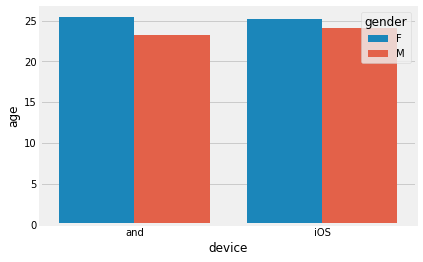

In [168]:
by_gender = total_subs.groupby(['gender','device'], as_index=False).mean()
sns.barplot(x=by_gender.device, y = by_gender.age, hue=by_gender.gender)

In [147]:
by_gender.mean()

,gender,device,age,price
0,F,and,25.414286,449.957143
1,F,iOS,25.212598,453.464567
2,M,and,23.273973,448.780822
3,M,iOS,24.120370,448.222222


In [215]:
b

NameError: name 'b' is not defined